In [ ]:
from attention_project_utils import * 
import pickle
import numpy as np
import pandas as pd
import glob
import tifffile
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import os
import matplotlib.lines as mlines
import scipy.cluster.hierarchy as sch
import sklearn
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.spatial.distance import cdist,squareform
from scipy import spatial,stats
from statistics import NormalDist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_dir = 'D:\\2P\\LCR_6mm_UV_DualCam\\'
fish_list = ['F2_13_30','F3_15_10','F4_19_00','F1_17_50','F2_12_20']
date_list = ['20221113']*3+['20221120']+['20221122']
visuomotor_list = ['ns','Prey','Freezing','Luminance','motor_Freezing','motor_PC']
fpv = 390/10
plane_no = 9

output_dir = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files_RGC'
create_directory(output_dir)


In [ ]:
def gen_regressor(x, tau, fps=3, record_trail=1):
    duration = int(length/(fps*record_trail)) *  (record_trail)
    print(length)
    t = np.arange(0, duration, duration/len(x))
    print(t.shape)
    if tau == 0:
        return x
    zeros = np.zeros_like(t)
    print(zeros.shape)
    padded = np.concatenate([zeros,x,zeros])
#     plt.plot(padded)
#     plt.show()
    kernel = np.concatenate([zeros, np.exp(-t / tau )])
    print( np.exp(-t / tau ))
#     plt.plot(kernel)
#     plt.show()
    convolved = np.convolve(padded, kernel, mode='same')[len(t):-len(t)]    
    if convolved.mean() == 0:
        return convolved
    return convolved / convolved.mean()

# def get_regression(df0f):

#     regressor = a
    
#     regr = linear_model.LinearRegression()  
#     x = regr.fit(regressor,df0f)
    
    
#     for i in range(0,len(df0f)):
#         df = pd.DataFrame (df0f[i])     
                 
        
#         listregcoeff.append(regr.coef_[0][0])  
#         listregintercept.append(x.intercept_[0])
#         r2 = r2_score(df, x.predict(X), multioutput='raw_values')
#         listr2.append(r2[0])  
    
#     return listregintercept,listregcoeff,listr2

def get_regression(df0f):
    listregintercept=[]
    listregcoeff=[]
    listr2=[] 
    
#     regressors = {'Dot': a, 'OKR': b, 'Loom': c}
    regressors = {'Dot': a}
#     print(regressors)
    X = pd.DataFrame(regressors,columns=['Dot']) 
#     print(X)
   
    for i in range(0,len(df0f)):
        if np.max(df0f[i]) == 0:
            listregcoeff.append(0)
            listregintercept.append(0)
            listr2.append(0)
        else:
            df = pd.DataFrame(df0f[i])     
            regr = linear_model.LinearRegression()           
            x = regr.fit(X,df)
            listregcoeff.append(regr.coef_[0][0])  
            listregintercept.append(x.intercept_[0])
            r2 = r2_score(df, x.predict(X), multioutput='raw_values')
            listr2.append(r2[0])  
    
    return listregintercept,listregcoeff,listr2

In [ ]:
list_calciumtraces = list(np.ones(39))
# length =len(list_calciumtraces[0])
length =len(list_calciumtraces)
# listprey,listokr,listloom = get_carbox(length)
listprey = np.concatenate([np.zeros(27),np.ones(3),np.zeros(9)])
# listokr = list(range(300,400))
# listloom = list(range(1700,1800))
print(listprey.shape)

a= gen_regressor(listprey,1.7)
a = (a-min(a))/(max(a)-min(a))

plt.plot(a,color='navy',linewidth = 3)
plt.axis('off')
plt.show()

In [ ]:
# Active pixel selection

# df_active_pixel_VMV = pd.DataFrame()

# for fish_i in range(0,len(date_list)):
# for fish_i in range(1,2):
for fish_i in range(2,len(date_list)):
    print(date_list[fish_i]+' '+fish_list[fish_i])
    temp_df_dfof = pd.read_csv(main_dir+date_list[fish_i]+'\\processed\\'+fish_list[fish_i]+'\\registration\\coordinates_AF10_reg3d.csv')
    
    vsinfo_dir = glob.glob(main_dir+date_list[fish_i]+'\\behavior\\'+fish_list[fish_i]+'\\vsinfo*.xlsx')[0]
    vsinfo = pd.read_excel(vsinfo_dir)
    bradyinfo_dir = glob.glob(main_dir+date_list[fish_i]+'\\behavior\\'+fish_list[fish_i]+'\\Bradyinfo*.xlsx')[0]
    Brady_info = pd.read_excel(bradyinfo_dir,sheet_name = 'Bradyinfo')
    trial_no = vsinfo.shape[0]
    for ii in range(0,len(visuomotor_list)):
        locals()['Index_'+str(visuomotor_list[ii])] = []
    for t in range(0,trial_no):
#         if Bad_Imaging_Quality_list.count(t) == 0:
        if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
            Index_ns.append(t)
        else:
            if Brady_info['Behavior_Classification'][t] == 'Freezing':
                Index_motor_Freezing.append(t)
            if Brady_info['Bradycardia_Classification'][t] == 0 and Brady_info['PC_trial'][t] == True:
                Index_motor_PC.append(t)
            if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 15:
                    Index_Freezing.append(t)
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                    Index_Prey.append(t)
            if vsinfo.Left_Stimulus_Type[t] == 'lum' or vsinfo.Right_Stimulus_Type[t] == 'lum':
                Index_Luminance.append(t)
    
    
    for plane_idx in range(1,10):
        temp_df_dfof_plane = temp_df_dfof.loc[np.where(temp_df_dfof['plane'] == plane_idx)[0],:]
        if temp_df_dfof_plane.shape[0]>0:
            print('Plane'+str(plane_idx))
            print('pixel no. is '+str(temp_df_dfof_plane.shape[0]))
            locals()['active_pixel_idx_f'+str(fish_i)+'_p'+str(plane_idx)] = list()
            if fish_i<2:
                file = glob.glob(main_dir+date_list[fish_i]+'\\processed\\'+fish_list[fish_i]+'\\motion_correction_suite2p\\plane'+str(plane_idx)+'\\combined_registered\\*')[0]
                temp_tif= tifffile.imread(file)
            else:
                file = glob.glob(main_dir+date_list[fish_i]+'\\processed\\'+fish_list[fish_i]+'\\registered_tif\\combined_registered\\combined*plane'+str(plane_idx)+'*')[0]
                temp_tif = tifffile.imread(file)
            
            np_r2_alltrials = np.zeros((temp_df_dfof_plane.shape[0],vsinfo.shape[0]))
            np_coeff_alltrials = np.zeros((temp_df_dfof_plane.shape[0],vsinfo.shape[0]))
 
            for trial in range(0,vsinfo.shape[0]):
                tracing = temp_tif[int(fpv*trial):int(fpv*(trial+1)),temp_df_dfof_plane['original_y'],temp_df_dfof_plane['original_x']]
                baseline = np.average(tracing[15:27],axis=0)
                delta_f = (tracing-baseline)/baseline
                sti_on_delta_f = np.average(delta_f[27:36,:],axis=0)
                # just in case baseline value is 0
                sti_on_delta_f[np.where(np.isinf(sti_on_delta_f))[0]] = 0
                sti_on_delta_f[np.where(np.isnan(sti_on_delta_f))[0]] = 0
                
                
                idx_pixel_large = np.where(sti_on_delta_f>0.4)[0]
                delta_f_large = delta_f[:,idx_pixel_large]
                delta_f_normed = (delta_f_large-np.min(delta_f_large,axis=0))/(np.max(delta_f_large,axis=0)-np.min(delta_f_large,axis=0))
                listregintercept,listregcoeff,listr2 = get_regression(delta_f_normed.T)
                
                np_r2_alltrials[idx_pixel_large,trial] = listr2
                np_coeff_alltrials[idx_pixel_large,trial] = listregcoeff
            
            for pixel_i in range(0,np_r2_alltrials.shape[0]):
                for VMV in visuomotor_list[1:]:
                    temp_index = locals()['Index_'+VMV]
                    temp_active_no = 0
                    for temp_trial_idx in temp_index:
                        if np_r2_alltrials[pixel_i,temp_trial_idx]>0.36 and np_coeff_alltrials[pixel_i,temp_trial_idx]>0.35:
                            temp_active_no = temp_active_no+1
                    if temp_active_no/len(temp_index)>0.3:
                        locals()['active_pixel_idx_f'+str(fish_i)+'_p'+str(plane_idx)].append(pixel_i)
                        break
            
            if len(locals()['active_pixel_idx_f'+str(fish_i)+'_p'+str(plane_idx)])>0:
                temp_df_dfof_plane_active = temp_df_dfof_plane.iloc[locals()['active_pixel_idx_f'+str(fish_i)+'_p'+str(plane_idx)],:]
                print('active pixel no. is '+str(temp_df_dfof_plane_active.shape[0]))
                for VMV in visuomotor_list:
                    index_temp = locals()['Index_'+VMV]
                    temp_averaged_score = np.zeros(len(locals()['active_pixel_idx_f'+str(fish_i)+'_p'+str(plane_idx)]))
                    for t in index_temp:
                        tracing = temp_tif[int(fpv*t):int(fpv*(t+1)),temp_df_dfof_plane_active['original_y'],temp_df_dfof_plane_active['original_x']]
                        baseline = np.average(tracing[15:27],axis=0)
                        delta_f = (tracing-baseline)/baseline
                        delta_f_normed = (delta_f-np.min(delta_f,axis=0))/(np.max(delta_f,axis=0)-np.min(delta_f,axis=0))
                        idx_baseline0 = np.where(baseline == 0)[0]
                        delta_f_normed[:,idx_baseline0] = 0
                        listregintercept,listregcoeff,listr2 = get_regression(delta_f_normed.T)
                        score_t = np.array(listregcoeff) * np.array(listr2)
                        temp_averaged_score = np.add(temp_averaged_score,score_t/len(index_temp))
                    temp_df_dfof_plane_active[VMV] = temp_averaged_score
                df_active_pixel_VMV = df_active_pixel_VMV.append(temp_df_dfof_plane_active,ignore_index=True)

In [ ]:
+
df_active_pixel_VMV.to_csv(output_dir+'\\df_VMV_5fish_AF10.csv',index=False)


In [ ]:
df_active_pixel_VMV = pd.read_csv(output_dir+'\\df_VMV_5fish_AF10.csv')

In [ ]:
df_active_pixel_VMV

In [ ]:
npy_VMV_all = df_active_pixel_VMV.iloc[:,-6:].to_numpy(dtype = 'float64')

corr = np.corrcoef(npy_VMV_all)
plt.imshow(corr)

In [ ]:
corr.shape

In [ ]:
+
d = sch.distance.pdist(corr)
np.save(output_dir+'\\AF10_d_v1.npy',d)

In [ ]:
d = np.load(output_dir+'\\AF10_d_v1.npy')

In [ ]:
L = sch.linkage(d, method='complete')

In [ ]:
from scipy.spatial.distance import squareform
silhouette_score(squareform(d), fcluster(L, t=3, criterion='maxclust'), metric = 'precomputed')

In [ ]:
def sil_scores(X, Z, ts):
    '''
    Creates a list of silhouette scores for a predetermined range of clusters.
    '''
    scores = []
    
    for num_clust in ts:
        scores.append(silhouette_score(squareform(X), fcluster(Z, t=num_clust, criterion='maxclust'), metric = 'precomputed'))
    
    return scores

scores = sil_scores(d, L, range(2,60))


# for t, s in zip(range(2,60), scores):
#     print(f"With {t} clusters, the silhouette score is {s}")

In [ ]:
plt.plot(range(2,60),scores)
plt.xlabel('# of cluster',fontsize = 15)
plt.ylabel('Silhouette Coefficient',fontsize = 15)
plt.axvline(x= 6,color = 'grey')
plt.annotate('cluster No. = 6',(6.8,0.3),fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Pixel clustering silhouette analysis',fontsize  =18)

plt.show()

In [ ]:
threshold_ratio = 0.3
clusters = sch.fcluster(L, threshold_ratio * d.max(), 'distance')
npy_VMV_all = df_active_pixel_VMV.iloc[:,8:14].to_numpy(dtype = 'float64')

npy_VMV_all_cluster = np.c_[npy_VMV_all, clusters]

df_active_pixel_VMV['cluster'] = clusters
clusters

In [ ]:
df_active_pixel_VMV['cluster'] = clusters
df_active_pixel_VMV.to_csv(output_dir+'\\df_VMV_pixel_37cluster_v6.csv',index=False)

In [ ]:
# 6 cluster
clusters = sch.fcluster(L, 6, 'maxclust')
npy_VMV_all_cluster = np.c_[npy_VMV_all, clusters]
clusters

In [ ]:
# vmv of different clusters

fig,[ax2,ax1,ax3]= plt.subplots(1,3,figsize = (18,14), gridspec_kw=dict(width_ratios=[.07, .85, .08]))

# fig = plt.figure(figsize = (12,14))
# ax2 = plt.subplot(131, gridspec_kw=dict(width_ratios=[.07, .85, .08]))
# ax1 = plt.subplot(132)
# ax3 = plt.subplot(235)
# d= sch.dendrogram(L, orientation='left', ax=ax4, color_threshold=threshold_ratio*d.max())

argsort = np.argsort(clusters)[::-1]
sns.heatmap(npy_VMV_all_cluster[argsort,:6],cmap = 'plasma',ax = ax1,vmin = -0.3,vmax = 0.7,cbar_ax = ax3)
sns.heatmap(npy_VMV_all_cluster[argsort,-1:],cmap = 'gist_ncar',cbar = False,ax = ax2)

ax1.set_yticks([]) 
ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing (motor)', 'Prey (motor)'],fontsize = 19)

for i in range(0,4):
    ax1.get_xticklabels()[i].set_color("maroon")
for i in range(4,6):
    ax1.get_xticklabels()[i].set_color("navy")
    
# ax2.set_ylabel('Neurons',fontsize = 18) 
ax2.set_yticks([]) 
ax2.set_xticklabels(['Cluster ID'],fontsize = 19)


line_x = np.where(clusters[argsort][:-1]-clusters[argsort][1:] ==1)
ax1.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)
ax2.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)

# cluster_idx=np.unique(clusters)
# for i in cluster_idx:
#     if np.where(clusters == i)[0].shape[0]>300:
#         ax2.annotate(str(i),(line_x[0][i-2]+10,0.5),fontsize = 20,color = 'black')
fig.subplots_adjust(wspace=0.02)

ax1.set_xlabel('Visuomotor Vectors',fontsize = 24)

ax3.set_ylabel('Averaged Visomotor Vector Score',fontsize = 24)
ax3.tick_params(labelsize=22)
plt.show()

In [ ]:
# vmv of different clusters

fig,[ax2,ax1,ax3]= plt.subplots(1,3,figsize = (18,14), gridspec_kw=dict(width_ratios=[.07, .85, .08]))

# fig = plt.figure(figsize = (12,14))
# ax2 = plt.subplot(131, gridspec_kw=dict(width_ratios=[.07, .85, .08]))
# ax1 = plt.subplot(132)
# ax3 = plt.subplot(235)
# d= sch.dendrogram(L, orientation='left', ax=ax4, color_threshold=threshold_ratio*d.max())

argsort = np.argsort(clusters)[::-1]
sns.heatmap(npy_VMV_all_cluster[argsort,:6],cmap = 'plasma',ax = ax1,vmin = -0.3,vmax = 0.7,cbar_ax = ax3)
sns.heatmap(npy_VMV_all_cluster[argsort,-1:],cmap = 'gist_ncar',cbar = False,ax = ax2)

ax1.set_yticks([]) 
ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing (motor)', 'Prey (motor)'],fontsize = 19)

for i in range(0,4):
    ax1.get_xticklabels()[i].set_color("maroon")
for i in range(4,6):
    ax1.get_xticklabels()[i].set_color("navy")
    
# ax2.set_ylabel('Neurons',fontsize = 18) 
ax2.set_yticks([]) 
ax2.set_xticklabels(['Cluster ID'],fontsize = 19)


line_x = np.where(clusters[argsort][:-1]-clusters[argsort][1:] ==1)
ax1.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)
ax2.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)

# cluster_idx=np.unique(clusters)
# for i in cluster_idx:
#     if np.where(clusters == i)[0].shape[0]>300:
#         ax2.annotate(str(i),(line_x[0][i-2]+10,0.5),fontsize = 20,color = 'black')
fig.subplots_adjust(wspace=0.02)

ax1.set_xlabel('Visuomotor Vectors',fontsize = 24)

ax3.set_ylabel('Averaged Visomotor Vector Score',fontsize = 24)
ax3.tick_params(labelsize=22)
plt.show()

In [ ]:
npy_VMV_all_cluster_normed = npy_VMV_all_cluster.copy()
# VMV_max = np.max(npy_VMV_all_cluster_normed[:,:6])
# VMV_min = np.min(npy_VMV_all_cluster_normed[:,:6])
# npy_VMV_all_cluster_normed[:,1] = (npy_VMV_all_cluster_normed[:,1]-VMV_min)/(VMV_max-VMV_min)
# npy_VMV_all_cluster_normed[:,2] = (npy_VMV_all_cluster_normed[:,2]-VMV_min)/(VMV_max-VMV_min)

In [ ]:
# 2d scatter plot of distribution of each cluster
from matplotlib.colors import LinearSegmentedColormap

fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
startcolor = 'crimson'
midcolor = '#FDFD96'
endcolor = 'dodgerblue'
cm = LinearSegmentedColormap.from_list( 'own2', [startcolor, midcolor, endcolor] )
scatter_info = np.zeros((len(cluster_idx),4))
color_cluster = np.zeros(npy_VMV_all_cluster.shape[0])
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    scatter_info[cluster_i,0] = average_temp_cluster[4]
    scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    color_cluster[locals()['cluster_'+str(i)+'_roi_idx']] = scatter_info[cluster_i,2]
    scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])

    if scatter_info[cluster_i,0]>0.1 and scatter_info[cluster_i,1]>0.1:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'both'
    elif scatter_info[cluster_i,0]<scatter_info[cluster_i,1]:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'PC'
    else:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'Freezing'
scatter_info[:,3] = scatter_info[:,3]/np.sum(scatter_info[:,3])

for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    if scatter_info[cluster_i,3]>0.04:
        ax1.annotate(str(i),(average_temp_cluster[4]-0.011,average_temp_cluster[5]-0.007),fontsize = 8)

sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]*1200,cmap = cm,vmin = -1,vmax = 1)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12,labelpad = -6)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1(4°)','-0.5','0','0.5','1(15°)'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.ylabel('Prey (motor) score',fontsize = 12)
plt.xlim(-0.06,0.36)
plt.ylim(-0.06,0.36)
plt.xticks([0,0.1,0.2,0.3])
plt.yticks([0,0.1,0.2,0.3])
# plt.plot([-1,0.08],[-1,0.08],linestyle='dashed',color = 'k')
# plt.plot([0.08,0.08],[0.08,1],linestyle='dashed',color = 'k')
# plt.plot([0.08,1],[0.08,0.08],linestyle='dashed',color = 'k')
# plt.title('Cluster Distribution(RGC pixels)')
plt.show()

In [ ]:
# vmv of different clusters

fig,[ax2,ax1,ax3]= plt.subplots(1,3,figsize = (12,14), gridspec_kw=dict(width_ratios=[.07, .89, .04]),dpi = 800)

# fig = plt.figure(figsize = (12,14))
# ax2 = plt.subplot(131, gridspec_kw=dict(width_ratios=[.07, .85, .08]))
# ax1 = plt.subplot(132)
# ax3 = plt.subplot(235)
# d= sch.dendrogram(L, orientation='left', ax=ax4, color_threshold=threshold_ratio*d.max())

argsort = np.argsort(color_cluster)[::-1]
reshape_color_cluster = color_cluster.reshape((color_cluster.shape[0],1))
sns.heatmap(npy_VMV_all_cluster[argsort,:6],cmap = 'plasma',ax = ax1,vmin = -0.3,vmax = 0.7,cbar_ax = ax3)
sns.heatmap(reshape_color_cluster[argsort,:],cmap = cm,vmin = -1,vmax = 1,cbar = False,ax = ax2)

ax1.set_yticks([]) 
# ax1.set_xticks([0.5,1.5,2.5,3.5,4.35,5.42])
ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing\n(motor)', 'Prey\n(motor)'],rotation = 20,fontsize = 24)

for i in range(0,4):
    ax1.get_xticklabels()[i].set_color("maroon")
for i in range(4,6):
    ax1.get_xticklabels()[i].set_color("navy")
    
# ax2.set_ylabel('Neurons',fontsize = 18) 
ax2.set_yticks([]) 
ax2.set_xticklabels(['Cluster ID'],rotation = 20,fontsize = 24)


line_x = np.where(reshape_color_cluster[argsort][:-1]-reshape_color_cluster[argsort][1:] !=0)
ax1.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)
ax2.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)

# cluster_idx=np.unique(clusters)
# for i in cluster_idx:
#     if np.where(clusters == i)[0].shape[0]>300:
#         ax2.annotate(str(i),(line_x[0][i-2]+10,0.5),fontsize = 20,color = 'black')
fig.subplots_adjust(wspace=0.02)

ax1.set_xlabel('Visuomotor Vectors',fontsize = 24)

ax3.set_ylabel('Average Visomotor Vector Score',fontsize = 24)
ax3.tick_params(labelsize=22)
plt.show()

In [ ]:
# 2d scatter plot of distribution of each cluster
from matplotlib.colors import LinearSegmentedColormap

fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
startcolor = 'crimson'
midcolor = '#FDFD96'
endcolor = 'dodgerblue'
cm = LinearSegmentedColormap.from_list( 'own2', [startcolor, midcolor, endcolor] )
# scatter_info = np.zeros((len(cluster_idx),4))
# for cluster_i in range(0,len(cluster_idx)):
#     i = int(cluster_idx[cluster_i])
#     locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
#     average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
#     scatter_info[cluster_i,0] = average_temp_cluster[4]
#     scatter_info[cluster_i,1] = average_temp_cluster[5]
#     scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
#     scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])

#     if scatter_info[cluster_i,0]>0.1 and scatter_info[cluster_i,1]>0.1:
#         index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
#         df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'both'
#     elif scatter_info[cluster_i,0]<scatter_info[cluster_i,1]:
#         index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
#         df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'PC'
#     else:
#         index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
#         df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'Freezing'
# scatter_info[:,3] = scatter_info[:,3]/np.sum(scatter_info[:,3])

# for cluster_i in range(0,len(cluster_idx)):
#     i = int(cluster_idx[cluster_i])
#     average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
#     if scatter_info[cluster_i,3]>0.04:
#         ax1.annotate(str(i),(average_temp_cluster[4]-0.0055,average_temp_cluster[5]-0.005),fontsize = 5)

sc = plt.scatter(npy_VMV_all_cluster_normed[:,4],npy_VMV_all_cluster_normed[:,5],c = (npy_VMV_all_cluster_normed[:,2]-npy_VMV_all_cluster_normed[:,1])/(npy_VMV_all_cluster_normed[:,2]+npy_VMV_all_cluster_normed[:,1]),s = 0.08,alpha = 0.7,cmap = cm,vmin = -0.5,vmax = 0.5,edgecolors=None)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12,labelpad = -6)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1(4°)','-0.5','0','0.5','1(15°)'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.ylabel('Prey (motor) score',fontsize = 12)
plt.xlim(-0.06,0.36)
plt.ylim(-0.06,0.36)
plt.xticks([0,0.1,0.2,0.3])
plt.yticks([0,0.1,0.2,0.3])
# plt.plot([-1,0.08],[-1,0.08],linestyle='dashed',color = 'k')
# plt.plot([0.08,0.08],[0.08,1],linestyle='dashed',color = 'k')
# plt.plot([0.08,1],[0.08,0.08],linestyle='dashed',color = 'k')
# plt.title('Cluster Distribution(RGC pixels)')
ax1.tick_params(direction='out', length=4, width=1)
plt.show()

In [ ]:
# 2d scatter plot of distribution of single units
from matplotlib.colors import LinearSegmentedColormap

fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
startcolor = 'crimson'
midcolor = '#FDFD96'
endcolor = 'dodgerblue'
cm = LinearSegmentedColormap.from_list( 'own2', [startcolor, midcolor, endcolor] )
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    scatter_info[cluster_i,0] = average_temp_cluster[4]
    scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])

    if scatter_info[cluster_i,0]>0.1 and scatter_info[cluster_i,1]>0.1:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'both'
    elif scatter_info[cluster_i,0]<scatter_info[cluster_i,1]:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'PC'
    else:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'Freezing'
scatter_info[:,3] = scatter_info[:,3]/np.sum(scatter_info[:,3])

for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    average_temp_cluster = np.average(npy_VMV_all_cluster_normed[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    if scatter_info[cluster_i,3]>0.04:
        ax1.annotate(str(i),(average_temp_cluster[4]-0.0055,average_temp_cluster[5]-0.005),fontsize = 5)

sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]*1200,cmap = cm,vmin = -1,vmax = 1)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12,labelpad = 6)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1(4°)','-0.5','0','0.5','1(15°)'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.ylabel('Prey (motor) score',fontsize = 12)
plt.xlim(-0.06,0.36)
plt.ylim(-0.06,0.36)
plt.xticks([0,0.1,0.2,0.3])
plt.yticks([0,0.1,0.2,0.3])
# plt.plot([-1,0.08],[-1,0.08],linestyle='dashed',color = 'k')
# plt.plot([0.08,0.08],[0.08,1],linestyle='dashed',color = 'k')
# plt.plot([0.08,1],[0.08,0.08],linestyle='dashed',color = 'k')
# plt.title('Cluster Distribution(RGC pixels)')
plt.show()

In [ ]:
df_active_pixel_VMV['cluster'] = clusters
df_active_pixel_VMV.to_csv(output_dir+'\\df_VMV_pixel_6cluster_v6.csv',index=False)

In [ ]:
# 2d scatter plot of distribution of each cluster
from matplotlib.colors import LinearSegmentedColormap

fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
startcolor = 'crimson'
midcolor = '#FDFD96'
endcolor = 'dodgerblue'
cm = LinearSegmentedColormap.from_list( 'own2', [startcolor, midcolor, endcolor] )
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    scatter_info[cluster_i,0] = average_temp_cluster[4]
    scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])
    if scatter_info[cluster_i,3]>500:
        ax1.annotate(str(i),(average_temp_cluster[4]-0.0055,average_temp_cluster[5]-0.005),fontsize = 5)
        
    if scatter_info[cluster_i,0]>0.1 and scatter_info[cluster_i,1]>0.1:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'both'
    elif scatter_info[cluster_i,0]<scatter_info[cluster_i,1]:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'PC'
    else:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'Freezing'
scatter_info[:,3] = scatter_info[:,3]/np.sum(scatter_info[:,3])
sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]*1200,cmap = cm,vmin = -1,vmax = 1)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12,labelpad = -6)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1(4°)','-0.5','0','0.5','1(15°)'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.ylabel('Prey (motor) score',fontsize = 12)
plt.xlim(-0.06,0.36)
plt.ylim(-0.06,0.36)
plt.xticks([0,0.1,0.2,0.3])
plt.yticks([0,0.1,0.2,0.3])
# plt.plot([-1,0.08],[-1,0.08],linestyle='dashed',color = 'k')
# plt.plot([0.08,0.08],[0.08,1],linestyle='dashed',color = 'k')
# plt.plot([0.08,1],[0.08,0.08],linestyle='dashed',color = 'k')
# plt.title('Cluster Distribution(RGC pixels)')
plt.show()

In [ ]:
line_x[0]

In [ ]:
cluster_idx=np.unique(clusters)
for i in cluster_idx:
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    fig,ax1 = plt.subplots(1,1,figsize = (17,3))
    sns.heatmap(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],cmap = 'plasma',ax = ax1,vmin = -0.3,vmax = 0.7)
    ax1.set_xticklabels(visuomotor_list,fontsize = 14)
    for j in range(0,4):
        ax1.get_xticklabels()[j].set_color("maroon")
    for k in range(4,6):
        ax1.get_xticklabels()[k].set_color("navy")
    ax1.set_yticks([]) 
    plt.title('Averaged activity of cluster'+str(i)+', n = '+str(len(locals()['cluster_'+str(i)+'_roi_idx'])),fontsize = 16)
    plt.show()
    

In [ ]:
df_active_pixel_VMV['cluster'] = clusters
df_active_pixel_VMV.to_csv(output_dir+'\\df_VMV_5fish_AF10_withcluster.csv',index=False)

In [ ]:
df_active_pixel_VMV = pd.read_csv(output_dir+'\\df_VMV_5fish_AF10_withcluster.csv')
clusters = df_active_pixel_VMV['cluster']

In [ ]:
# anatomical location
cluster_idx=np.unique(clusters)
atlas_path = 'D:\\2P\\T_AVG_ath5cre.tif'
atlas = tifffile.imread(atlas_path)
mask_xy_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xy.tif'
mask_xy = tifffile.imread(mask_xy_path)
mask_xz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xz.tif'
mask_xz = tifffile.imread(mask_xz_path)
mask_yz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_yz.tif'
mask_yz = tifffile.imread(mask_yz_path)

for temp_cluster_id in cluster_idx:
    print('Cluster'+str(temp_cluster_id))
    i = int(temp_cluster_id)
    colorcode = 'red'
    size = 0.005

    xy_cropping = [200,559,0,597]
    xz_cropping = [0,359,0,597]
    yz_cropping = [0,359,0,597]
    
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    if len(locals()['cluster_'+str(i)+'_roi_idx'])>100:
        fig,ax1 = plt.subplots(1,1,figsize = (18,3))
        sns.heatmap(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],cmap = 'plasma',cbar_kws={'label':'Averaged Visomotor Vector Score','pad':0.02},ax = ax1,vmin = -0.3,vmax = 0.7)
        ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing (motor)', 'Prey (motor)'],fontsize = 18)
        ax1.figure.axes[-1].yaxis.label.set_size(12)
        ax1.figure.axes[-1].tick_params(labelsize=14)
        for j in range(0,4):
            ax1.get_xticklabels()[j].set_color("maroon")
        for k in range(4,6):
            ax1.get_xticklabels()[k].set_color("navy")
        ax1.set_yticks([]) 
    #     plt.title('Averaged activity of cluster'+str(i)+', n = '+str(len(locals()['cluster_'+str(i)+'_roi_idx'])),fontsize = 16)
        plt.title('Averaged activity of cluster'+str(i)+', n = '+str(len(locals()['cluster_'+str(i)+'_roi_idx'])),fontsize = 22)
        plt.show()
    
    

        xy = np.mean(atlas,axis = 0)
        yz = np.mean(atlas,axis = 2)
        xz = np.mean(atlas,axis = 1)
        rotated_yz = np.zeros((yz.shape[0],yz.shape[1]))
        rotated_xz = np.zeros((xz.shape[0],xz.shape[1]))

        for z in range(0,yz.shape[0]):
            rotated_yz[z,:] = yz[yz.shape[0]-1-z,:]
            rotated_xz[z,:] = xz[xz.shape[0]-1-z,:]

        
        X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
        Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
        Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
        
        filtered_idx = []
        for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
            if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
                filtered_idx.append(i)


        fig,axes = plt.subplots(1, 3,figsize = (9,3),subplot_kw=dict(box_aspect=3.59/5.97),dpi=800)

        ax = sns.heatmap(xy[xy_cropping[0]:xy_cropping[1],xy_cropping[2]:xy_cropping[3]],ax = axes[0],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
        axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size)
        axes[0].axis('off')


        ax = sns.heatmap(rotated_xz[xz_cropping[0]:xz_cropping[1],xz_cropping[2]:xz_cropping[3]],ax = axes[1],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
        axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size)
        axes[1].axis('off')


        ax = sns.heatmap(rotated_yz[yz_cropping[0]:yz_cropping[1],yz_cropping[2]:yz_cropping[3]],ax = axes[2],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
        axes[2].scatter(np.array(Y)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size)
        axes[2].axis('off')

        cols = ['Horizontal','Coronal','Sagittal']
        pad = 5 
        for ax, col in zip(axes, cols):
            ax.annotate(col, xy=(0.5, 1.04), xytext=(0, pad),
                        xycoords='axes fraction', textcoords='offset points',
                        size=18, ha='center', va='baseline')


        fig.tight_layout()
        plt.show()

In [ ]:
# atlas_path = 'D:\\2P\\T_AVG_ath5cre.tif'
# atlas = tifffile.imread(atlas_path)
# mask_xy_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xy.tif'
# mask_xy = tifffile.imread(mask_xy_path)
# mask_xz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xz.tif'
# mask_xz = tifffile.imread(mask_xz_path)
# mask_yz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_yz.tif'
# mask_yz = tifffile.imread(mask_yz_path)

cluster_idx_15 = [36,35,26]
cluster_idx_4 = [22,19,15]
cluster_idx_both = [29,24]

size = 0.003
alpha = 1

xy = np.mean(atlas,axis = 0)
yz = np.mean(atlas,axis = 2)
xz = np.mean(atlas,axis = 1)
rotated_yz = np.zeros((yz.shape[0],yz.shape[1]))
rotated_xz = np.zeros((xz.shape[0],xz.shape[1]))

xy_cropping = [200,559,0,597]
xz_cropping = [0,359,0,597]
yz_cropping = [0,359,0,597]
    
for z in range(0,yz.shape[0]):
    rotated_yz[z,:] = yz[yz.shape[0]-1-z,:]
    rotated_xz[z,:] = xz[xz.shape[0]-1-z,:]

fig,axes = plt.subplots(1, 3,figsize = (17,5),subplot_kw=dict(box_aspect=3.59/5.97),dpi=1200)
ax = sns.heatmap(xy[xy_cropping[0]:xy_cropping[1],xy_cropping[2]:xy_cropping[3]],ax = axes[0],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
ax = sns.heatmap(rotated_xz[xz_cropping[0]:xz_cropping[1],xz_cropping[2]:xz_cropping[3]],ax = axes[1],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
ax = sns.heatmap(rotated_yz[yz_cropping[0]:yz_cropping[1],yz_cropping[2]:yz_cropping[3]],ax = axes[2],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)


    
for temp_cluster_id in cluster_idx_15:
    colorcode = 'dodgerblue'
    i = int(temp_cluster_id)
    X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
    Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
    Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
    filtered_idx = []
    for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
        if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
            filtered_idx.append(i)
    
    axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[0].axis('off')
    
    axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[1].axis('off') 
    
    axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[2].axis('off')

for temp_cluster_id in cluster_idx_4:
    colorcode = 'coral'
    i = int(temp_cluster_id)
    X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
    Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
    Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
    filtered_idx = []
    for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
        if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
            filtered_idx.append(i)
    
    axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[0].axis('off')

    axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[1].axis('off') 
    
    axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[2].axis('off')


for temp_cluster_id in cluster_idx_both:
    colorcode = '#FFCC00'
    i = int(temp_cluster_id)
    X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
    Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
    Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
    filtered_idx = []
    for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
        if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
            filtered_idx.append(i)
    
    axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[0].axis('off')

    axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[1].axis('off') 
    
    axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[2].axis('off')


cols = ['Horizontal','Coronal','Sagittal']
pad = 5 
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.04), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')


fig.tight_layout()
plt.show()

In [ ]:
atlas_path = 'D:\\2P\\T_AVG_ath5cre.tif'
atlas = tifffile.imread(atlas_path)
mask_xy_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xy.tif'
mask_xy = tifffile.imread(mask_xy_path)
mask_xz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_xz.tif'
mask_xz = tifffile.imread(mask_xz_path)
mask_yz_path = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files\\Mask_yz.tif'
mask_yz = tifffile.imread(mask_yz_path)

cluster_idx_15 = [36,35,26]
cluster_idx_4 = [22,19,15]
cluster_idx_both = [29,24]
df_active_pixel_VMV['cluster'] = clusters
size = 0.003
alpha = 1

xy = np.mean(atlas,axis = 0)
yz = np.mean(atlas,axis = 2)
xz = np.mean(atlas,axis = 1)
rotated_yz = np.zeros((yz.shape[0],yz.shape[1]))
rotated_xz = np.zeros((xz.shape[0],xz.shape[1]))

xy_cropping = [200,559,0,597]
xz_cropping = [0,359,0,597]
yz_cropping = [0,359,0,597]
    
for z in range(0,yz.shape[0]):
    rotated_yz[z,:] = yz[yz.shape[0]-1-z,:]
    rotated_xz[z,:] = xz[xz.shape[0]-1-z,:]

fig,axes = plt.subplots(1, 3,figsize = (17,5),subplot_kw=dict(box_aspect=3.59/5.97),dpi=1200)
ax = sns.heatmap(xy[xy_cropping[0]:xy_cropping[1],xy_cropping[2]:xy_cropping[3]],ax = axes[0],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
ax = sns.heatmap(rotated_xz[xz_cropping[0]:xz_cropping[1],xz_cropping[2]:xz_cropping[3]],ax = axes[1],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)
ax = sns.heatmap(rotated_yz[yz_cropping[0]:yz_cropping[1],yz_cropping[2]:yz_cropping[3]],ax = axes[2],cmap = 'gray',cbar = False,vmin = 0,vmax = 30)


    
for temp_cluster_id in cluster_idx_15:
    colorcode = 'dodgerblue'
    i = int(temp_cluster_id)
    X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
    Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
    Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
    filtered_idx = []
    for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
        if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
            filtered_idx.append(i)
    
    axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[0].axis('off')
    
    axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[1].axis('off') 
    
    axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[2].axis('off')

for temp_cluster_id in cluster_idx_4:
    colorcode = 'coral'
    i = int(temp_cluster_id)
    X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
    Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
    Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
    filtered_idx = []
    for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
        if x<597 and x>0 and y<974 and y>0:
#                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
            filtered_idx.append(i)
    
    axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[0].axis('off')

    axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[1].axis('off') 
    
    axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
    axes[2].axis('off')


# for temp_cluster_id in cluster_idx_both:
#     colorcode = '#FFCC00'
#     i = int(temp_cluster_id)
#     X = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].x/0.994
#     Y = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].y/0.994
#     Z = df_active_pixel_VMV[df_active_pixel_VMV['cluster']==temp_cluster_id].z
#     filtered_idx = []
#     for x,y,z,i in zip(X,Y,Z,range(0,X.shape[0])):
#         if x<597 and x>0 and y<974 and y>0:
# #                 if mask_xy[int(y),int(x)] == 255 and mask_xz[int(z),int(y)] == 255 and mask_yz[int(z),int(x)] == 255:
#             filtered_idx.append(i)
    
#     axes[0].scatter(np.array(X)[filtered_idx]-xy_cropping[2],np.array(Y)[filtered_idx]-xy_cropping[0],color = colorcode,s = size,alpha = alpha)
#     axes[0].axis('off')

#     axes[1].scatter(np.array(X)[filtered_idx]-xz_cropping[2],358-np.array(Z)[filtered_idx]-xz_cropping[0],color = colorcode,s = size,alpha = alpha)
#     axes[1].axis('off') 
    
#     axes[2].scatter(np.array(Y)[filtered_idx]-yz_cropping[2],358-np.array(Z)[filtered_idx]-yz_cropping[0],color = colorcode,s = size,alpha = alpha)
#     axes[2].axis('off')


cols = ['Horizontal','Coronal','Sagittal']
pad = 5 
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.04), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')


fig.tight_layout()
plt.show()

In [ ]:
df_active_pixel_VMV

# calculate normalized motor Freezing and motor Prey index
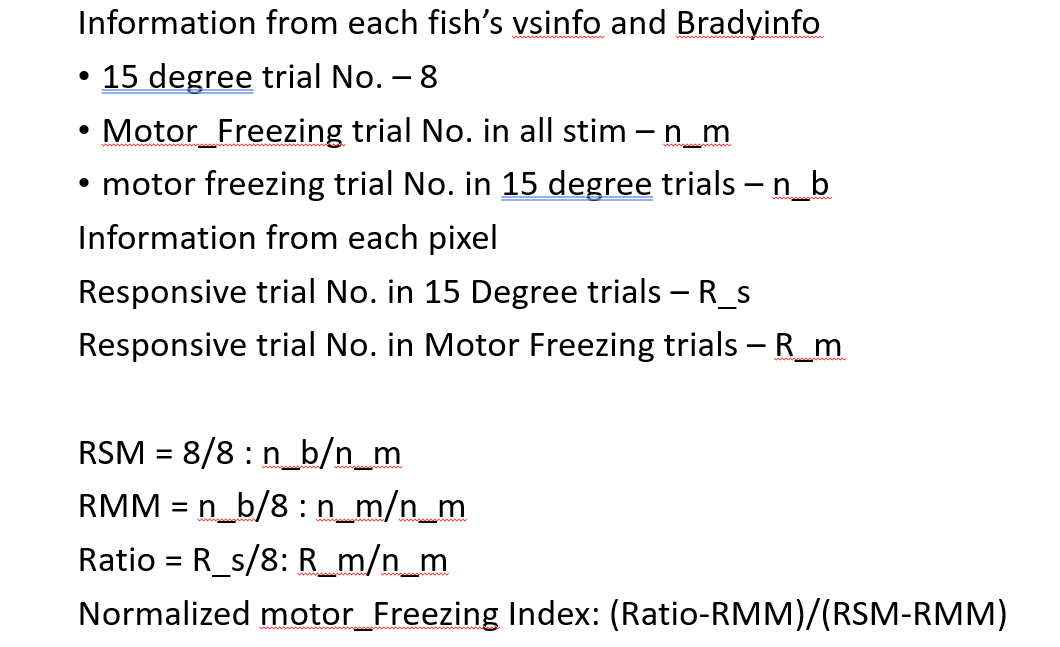


In [ ]:
# original
df_active_pixel_normed_ratio = pd.DataFrame()
for fish_i in range(0,len(date_list)):
    print(date_list[fish_i]+' '+fish_list[fish_i])
    vsinfo_dir = glob.glob(main_dir+date_list[fish_i]+'\\behavior\\'+fish_list[fish_i]+'\\vsinfo*.xlsx')[0]
    vsinfo = pd.read_excel(vsinfo_dir)
    bradyinfo_dir = glob.glob(main_dir+date_list[fish_i]+'\\behavior\\'+fish_list[fish_i]+'\\Bradyinfo*.xlsx')[0]
    Brady_info = pd.read_excel(bradyinfo_dir,sheet_name = 'Bradyinfo')
    trial_no = vsinfo.shape[0]
    
    Index_nm_Freezing = []
    Index_nm_PC = []
    Index_nb_Freezing = []
    Index_nb_PC = []
    Index_Freezing = []
    Index_Prey = []
    
    for t in range(0,trial_no):
#         if Bad_Imaging_Quality_list.count(t) == 0:
        if vsinfo.Left_Stimulus_Type[t] != 'n' or vsinfo.Right_Stimulus_Type[t] != 'n':
            if Brady_info['Behavior_Classification'][t] == 'Freezing':
                Index_nm_Freezing.append(t)
            if Brady_info['Bradycardia_Classification'][t] == 0 and Brady_info['PC_trial'][t] == True:
                Index_nm_PC.append(t)
            if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 15:
                    Index_Freezing.append(t)
                    if Brady_info['Behavior_Classification'][t] == 'Freezing':
                        Index_nb_Freezing.append(t)
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                    Index_Prey.append(t)
                    if Brady_info['Bradycardia_Classification'][t] == 0 and Brady_info['PC_trial'][t] == True:
                        Index_nb_PC.append(t)
    RSM_freezing = 1/(len(Index_nb_Freezing)/len(Index_nm_Freezing))
    RMM_freezing = len(Index_nb_Freezing)/8
    print(RSM_freezing)
    print(RMM_freezing)
    
    RSM_Prey = 1/(len(Index_nb_PC)/len(Index_nm_PC))
    RMM_Prey = len(Index_nb_PC)/8
    print(RSM_Prey)
    print(RMM_Prey)
    
    temp_df_fish = df_active_pixel_VMV[df_active_pixel_VMV['fish']==fish_list[fish_i]+'_'+date_list[fish_i]]
    for plane_idx in range(1,10):
        temp_df_plane = temp_df_fish[temp_df_fish['plane']==plane_idx]
        if temp_df_plane.shape[0]>0:
            
            if fish_i<2:
                file = glob.glob(main_dir+date_list[fish_i]+'\\processed\\'+fish_list[fish_i]+'\\motion_correction_suite2p\\plane'+str(plane_idx)+'\\combined_registered\\*')[0]
                temp_tif= tifffile.imread(file)
            else:
                file = glob.glob(main_dir+date_list[fish_i]+'\\processed\\'+fish_list[fish_i]+'\\registered_tif\\combined_registered\\combined*plane'+str(plane_idx)+'*')[0]
                temp_tif = tifffile.imread(file)
            
            rs_Freezing = np.zeros(temp_df_plane.shape[0])
            for trial in Index_Freezing:
                tracing = temp_tif[int(fpv*trial):int(fpv*(trial+1)),temp_df_plane['original_y'],temp_df_plane['original_x']]
                baseline = np.average(tracing[15:27],axis=0)
                delta_f = (tracing-baseline)/baseline
                sti_on_delta_f = np.average(delta_f[27:36,:],axis=0)
                # just in case baseline value is 0
                sti_on_delta_f[np.where(np.isinf(sti_on_delta_f))[0]] = 0
                sti_on_delta_f[np.where(np.isnan(sti_on_delta_f))[0]] = 0
                rs_Freezing = rs_Freezing +(sti_on_delta_f>1).astype(int)
            
            rm_Freezing = np.zeros(temp_df_plane.shape[0])
            for trial in Index_nm_Freezing:
                tracing = temp_tif[int(fpv*trial):int(fpv*(trial+1)),temp_df_plane['original_y'],temp_df_plane['original_x']]
                baseline = np.average(tracing[15:27],axis=0)
                delta_f = (tracing-baseline)/baseline
                sti_on_delta_f = np.average(delta_f[27:36,:],axis=0)
                # just in case baseline value is 0
                sti_on_delta_f[np.where(np.isinf(sti_on_delta_f))[0]] = 0
                sti_on_delta_f[np.where(np.isnan(sti_on_delta_f))[0]] = 0
                rm_Freezing = rm_Freezing +(sti_on_delta_f>1).astype(int)
                
            rs_PC = np.zeros(temp_df_plane.shape[0])
            for trial in Index_Prey:
                tracing = temp_tif[int(fpv*trial):int(fpv*(trial+1)),temp_df_plane['original_y'],temp_df_plane['original_x']]
                baseline = np.average(tracing[15:27],axis=0)
                delta_f = (tracing-baseline)/baseline
                sti_on_delta_f = np.average(delta_f[27:36,:],axis=0)
                # just in case baseline value is 0
                sti_on_delta_f[np.where(np.isinf(sti_on_delta_f))[0]] = 0
                sti_on_delta_f[np.where(np.isnan(sti_on_delta_f))[0]] = 0
                rs_PC = rs_PC +(sti_on_delta_f>1).astype(int)
            
            rm_PC = np.zeros(temp_df_plane.shape[0])
            for trial in Index_nm_PC:
                tracing = temp_tif[int(fpv*trial):int(fpv*(trial+1)),temp_df_plane['original_y'],temp_df_plane['original_x']]
                baseline = np.average(tracing[15:27],axis=0)
                delta_f = (tracing-baseline)/baseline
                sti_on_delta_f = np.average(delta_f[27:36,:],axis=0)
                # just in case baseline value is 0
                sti_on_delta_f[np.where(np.isinf(sti_on_delta_f))[0]] = 0
                sti_on_delta_f[np.where(np.isnan(sti_on_delta_f))[0]] = 0
                rm_PC = rm_PC +(sti_on_delta_f>1).astype(int)
            
            ratio_Freezing = (rs_Freezing/8)/(rm_Freezing/len(Index_nm_Freezing))
            ratio_Freezing[np.where(np.isinf(ratio_Freezing))[0]] = RMM_freezing # pure sensory, after normalization it would be 0
            ratio_Freezing[np.where(np.isnan(ratio_Freezing))[0]] = RSM_freezing/2+RMM_freezing/2
#             ratio_Freezing[np.where(ratio_Freezing==0)[0]] = RSM_freezing
            
            ratio_PC = (rs_PC/8)/(rm_PC/len(Index_nm_PC))
            ratio_PC[np.where(np.isinf(ratio_PC))[0]] = RMM_Prey
            ratio_PC[np.where(np.isnan(ratio_PC))[0]] = RSM_Prey/2+RMM_Prey/2
#             ratio_PC[np.where(ratio_PC==0)[0]] = RSM_Prey

            
            temp_df_plane['normed_ratio_Freezing'] = (ratio_Freezing-RSM_freezing)/(RMM_freezing-RSM_freezing)
            temp_df_plane['normed_ratio_PC'] = (ratio_PC-RSM_Prey)/(RMM_Prey-RSM_Prey)
            df_active_pixel_normed_ratio = df_active_pixel_normed_ratio.append(temp_df_plane)
            

In [ ]:
# 2d scatter plot of distribution of each cluster
fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
npy_VMV_all_cluster = df_active_pixel_VMV.iloc[:,-7:].to_numpy()
clusters = df_active_pixel_normed_ratio.cluster
cluster_idx=np.unique(clusters)
cm = plt.cm.get_cmap('RdYlBu')
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    scatter_info[cluster_i,0] = np.average(df_active_pixel_normed_ratio.loc[locals()['cluster_'+str(i)+'_roi_idx'],'normed_ratio_Freezing'])
    scatter_info[cluster_i,1] = np.average(df_active_pixel_normed_ratio.loc[locals()['cluster_'+str(i)+'_roi_idx'],'normed_ratio_PC'])
                               
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:4],axis = 0)
#     scatter_info[cluster_i,0] = average_temp_cluster[4]
#     scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = int(len(locals()['cluster_'+str(i)+'_roi_idx']))
    if scatter_info[cluster_i,3]>100:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.02,scatter_info[cluster_i,1]-0.01),fontsize = 5)
sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]/9,cmap = cm,vmin = -1,vmax = 1,alpha = 0.6)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Score of Freezing(motor)',fontsize = 12)
plt.ylabel('Score of Prey(motor)',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axvline(x=0.5,color = 'grey',alpha = 0.3,linewidth = 1)
plt.axhline(y=0.5,color = 'grey',alpha = 0.3,linewidth = 1)
plt.xticks([0,0.5,1.0])
plt.yticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(AF10)')
plt.show()

In [ ]:
# 2d scatter plot of distribution of each cluster
from matplotlib.colors import LinearSegmentedColormap

fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
# npy_VMV_all_cluster = df_active_pixel_VMV.iloc[:,-8:-1].to_numpy()
cluster_idx=np.unique(clusters)
startcolor = 'crimson'
midcolor = '#FDFD96'
endcolor = 'dodgerblue'
cm = LinearSegmentedColormap.from_list( 'own2', [startcolor, midcolor, endcolor] )
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    scatter_info[cluster_i,0] = average_temp_cluster[4]
    scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])
    if scatter_info[cluster_i,3]>500:
        ax1.annotate(str(i),(average_temp_cluster[4]-0.0055,average_temp_cluster[5]-0.005),fontsize = 5)
        
    if scatter_info[cluster_i,0]>0.1 and scatter_info[cluster_i,1]>0.1:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'both'
    elif scatter_info[cluster_i,0]<scatter_info[cluster_i,1]:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'PC'
    else:
        index_temp = df_active_pixel_VMV.iloc[locals()['cluster_'+str(i)+'_roi_idx'],:].index
        df_active_pixel_VMV.loc[index_temp,'cluster_type'] = 'Freezing'
scatter_info[:,3] = scatter_info[:,3]/np.sum(scatter_info)
sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]*1200,cmap = cm,vmin = -1,vmax = 1)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12,labelpad = -6)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1(4°)','-0.5','0','0.5','1(15°)'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.ylabel('Prey (motor) score',fontsize = 12)
plt.xlim(-0.06,0.36)
plt.ylim(-0.06,0.36)
plt.xticks([0,0.1,0.2,0.3])
plt.yticks([0,0.1,0.2,0.3])
# plt.plot([-1,0.08],[-1,0.08],linestyle='dashed',color = 'k')
# plt.plot([0.08,0.08],[0.08,1],linestyle='dashed',color = 'k')
# plt.plot([0.08,1],[0.08,0.08],linestyle='dashed',color = 'k')
# plt.title('Cluster Distribution(RGC pixels)')
plt.show()

In [ ]:
df_active_pixel_normed_ratio

In [ ]:
df_active_pixel_normed_ratio.to_csv(output_dir+'\\df_normed_ratio_ath5.csv',index=False)

In [ ]:
df_active_pixel_normed_ratio_Freezing = df_active_pixel_normed_ratio[df_active_pixel_normed_ratio['cluster_type']!='PC']
df_active_pixel_normed_ratio_PC = df_active_pixel_normed_ratio[df_active_pixel_normed_ratio['cluster_type']!='Freezing']

cluster_idx_Freezing = np.unique(df_active_pixel_normed_ratio_Freezing.cluster)
cluster_idx_PC = np.unique(df_active_pixel_normed_ratio_PC.cluster)

# freezing 
fig,ax1 = plt.subplots(1,1,figsize = (4,1),dpi=800)
scatter_info = np.zeros((len(cluster_idx_Freezing),4))
for cluster_i in range(0,len(cluster_idx_Freezing)):
    i = int(cluster_idx_Freezing[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(df_active_pixel_normed_ratio.cluster == i)[0])
    scatter_info[cluster_i,0] = np.average(df_active_pixel_normed_ratio.iloc[locals()['cluster_'+str(i)+'_roi_idx'],-2])
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:4],axis = 0)
    scatter_info[cluster_i,1] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,2] = int(len(locals()['cluster_'+str(i)+'_roi_idx']))
    scatter_info[cluster_i,3] = int(i)
    if i==34:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.035,0),fontsize = 4)
    elif scatter_info[cluster_i,2]>500:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.015,0),fontsize = 4)
#     if scatter_info[cluster_i,2]>500:
#         ax1.annotate(str(i),(scatter_info[cluster_i,0],0),fontsize = 6)
sc = plt.scatter(scatter_info[:,0],np.zeros(scatter_info.shape[0]),c = scatter_info[:,1],s = scatter_info[:,2]/12,cmap = cm,vmin = -1,vmax = 1,alpha = 0.6)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
plt.xlabel('Score of Freezing(motor)',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.xticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(Freezing)')
plt.show()

fig,ax1 = plt.subplots(1,1,figsize = (4,1),dpi=800)
scatter_info = np.zeros((len(cluster_idx_PC),4))
for cluster_i in range(0,len(cluster_idx_PC)):
    i = int(cluster_idx_PC[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(df_active_pixel_normed_ratio.cluster == i)[0])
    scatter_info[cluster_i,0] = np.average(df_active_pixel_normed_ratio.iloc[locals()['cluster_'+str(i)+'_roi_idx'],-1])
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:4],axis = 0)
    scatter_info[cluster_i,1] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,2] = int(len(locals()['cluster_'+str(i)+'_roi_idx']))
    scatter_info[cluster_i,3] = int(i)
    if i==15:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.03,0),fontsize = 4)
    elif i==27:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]+0.005,0),fontsize = 4)
    elif scatter_info[cluster_i,2]>1200:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.015,0),fontsize = 4)
sc = plt.scatter(scatter_info[:,0],np.zeros(scatter_info.shape[0]),c = scatter_info[:,1],s = scatter_info[:,2]/12,cmap = cm,vmin = -1,vmax = 1,alpha = 0.6)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
plt.xlabel('Score of PC(motor)',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.xticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(PC)')
plt.show()

In [ ]:
scatter_info[:,2] = scatter_info[:,2]/np.sum(scatter_info[:,2])
scatter_info

In [ ]:
df_active_pixel_normed_ratio_Freezing = df_active_pixel_normed_ratio[df_active_pixel_normed_ratio['cluster_type']!='PC']
df_active_pixel_normed_ratio_PC = df_active_pixel_normed_ratio[df_active_pixel_normed_ratio['cluster_type']!='Freezing']

cluster_idx_Freezing = np.unique(df_active_pixel_normed_ratio_Freezing.cluster)
cluster_idx_PC = np.unique(df_active_pixel_normed_ratio_PC.cluster)

# freezing 
fig,ax1 = plt.subplots(1,1,figsize = (4,1),dpi=800)
# scatter_info = np.zeros((len(cluster_idx_Freezing),3))
# for cluster_i in range(0,len(cluster_idx_Freezing)):
#     i = int(cluster_idx_Freezing[cluster_i])
#     locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(df_active_pixel_normed_ratio.cluster == i)[0])
#     scatter_info[cluster_i,0] = np.average(df_active_pixel_normed_ratio.iloc[locals()['cluster_'+str(i)+'_roi_idx'],-2])
#     average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:4],axis = 0)
#     scatter_info[cluster_i,1] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
#     scatter_info[cluster_i,2] = int(len(locals()['cluster_'+str(i)+'_roi_idx']))
#     if scatter_info[cluster_i,2]>500:
#         ax1.annotate(str(i),(scatter_info[cluster_i,0],0),fontsize = 6)
# sc = plt.scatter(scatter_info[:,0],np.zeros(scatter_info.shape[0]),c = scatter_info[:,1],s = scatter_info[:,2]/12,cmap = cm,vmin = -1,vmax = 1,alpha = 0.6)
sns.distplot(df_active_pixel_normed_ratio_Freezing['normed_ratio_Freezing'],kde=False)
# sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
# sc_cbar.set_label(label='Size Preference',size=12)
# sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
# sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
plt.xlabel('Freezing (motor) score',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.xticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(Freezing)')
plt.show()


# prey
fig,ax1 = plt.subplots(1,1,figsize = (4,1),dpi=800)
sns.distplot(df_active_pixel_normed_ratio_PC['normed_ratio_PC'],kde = False)
plt.xlabel('PC (motor) score',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.xticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(PC)')
plt.show()


In [ ]:
df_active_pixel_normed_ratio_Freezing

In [ ]:
df_active_pixel_normed_ratio['cluster_type'] = df_active_pixel_VMV['cluster_type']

In [ ]:
df_active_pixel_normed_ratio

In [ ]:
# 2d scatter plot of distribution of each cluster
fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
cm = plt.cm.get_cmap('RdYlBu')
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    scatter_info[cluster_i,0] = np.average(df_active_pixel_normed_ratio.loc[locals()['cluster_'+str(i)+'_roi_idx'],'normed_ratio_Freezing'])
    scatter_info[cluster_i,1] = np.average(df_active_pixel_normed_ratio.loc[locals()['cluster_'+str(i)+'_roi_idx'],'normed_ratio_PC'])
                               
    average_temp_cluster = np.average(npy_VMV_all_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:4],axis = 0)
#     scatter_info[cluster_i,0] = average_temp_cluster[4]
#     scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = int(len(locals()['cluster_'+str(i)+'_roi_idx']))
    if scatter_info[cluster_i,3]>100:
        ax1.annotate(str(i),(scatter_info[cluster_i,0]-0.02,scatter_info[cluster_i,1]-0.01),fontsize = 5)
sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]/9,cmap = cm,vmin = -1,vmax = 1,alpha = 0.6)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Score of Freezing(motor)',fontsize = 12)
plt.ylabel('Score of Prey(motor)',fontsize = 12)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axvline(x=0.5,color = 'grey',alpha = 0.3,linewidth = 1)
plt.axhline(y=0.5,color = 'grey',alpha = 0.3,linewidth = 1)
plt.xticks([0,0.5,1.0])
plt.yticks([0,0.5,1.0])
plt.title('Cluster Distribution in RGC dataset(AF10)')
plt.show()

# Spatial p value test

In [ ]:
def reject_outliers(data, m = 3.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zero(len(d))
    return data[s<m]

In [ ]:
main_dir = 'D:\\2P\\LCR_6mm_UV_DualCam\\'
fish_list = ['F2_13_30','F3_15_10','F4_19_00','F1_17_50','F2_12_20']
date_list = ['20221113']*3+['20221120']+['20221122']
visuomotor_list = ['ns','Prey','Freezing','Luminance','motor_Freezing','motor_PC']
fpv = 390/10
plane_no = 9
random_no = 2000

output_dir = 'C:\\Users\\yxton\\Documents\\Code\\2p\\freezing_project\\clustering_files_RGC'

df_VMV_all = pd.read_csv(output_dir+'\\df_VMV_5fish_AF10_withcluster.csv')

In [ ]:
df_VMV_all

In [ ]:
clusters_large = []
df_id_list = []
# trace_filtered_list = []

# df_filtered_reg_clusters = pd.DataFrame(columns = ['index','x','y','z','cluster','date','fish'])
df_filtered_VMV_all = pd.DataFrame(columns=df_VMV_all.columns)

clusters = np.unique(df_VMV_all.cluster)
for cluster_i in clusters:
    temp_df = df_VMV_all[df_VMV_all['cluster']== cluster_i]
    if temp_df.shape[0]>10:
        clusters_large.append(cluster_i)
        
for temp_fish,temp_date in zip(fish_list,date_list):
    df_id = temp_fish+'_'+temp_date
    df_id_list.append(df_id)
    locals()['df_'+df_id] = df_VMV_all[df_VMV_all['fish'] == df_id]
    for cluster_i in clusters_large:
        locals()['df_'+df_id+'_cluster'+str(cluster_i)] = locals()['df_'+df_id][locals()['df_'+df_id]['cluster']==cluster_i]
        
# loop for each neuron in df_reg_clusters
for i in range(0,df_VMV_all.shape[0]):
    # first see whether it's a neuron in a cluster size>10:
    temp_cluster_id = df_VMV_all['cluster'][i]
    if clusters_large.count(temp_cluster_id)>0:
        print(str(i)+'/'+str(df_VMV_all.shape[0]),end='\r')
        #basic info of this neuron
        temp_coor = list(df_VMV_all.iloc[i,0:3]) #need to check whether there is an unnamed column
        temp_df_id = df_VMV_all['fish'][i]
        
        dr_list = []
        #calculate dr of this neuron
        for df_id in df_id_list:
            if df_id != temp_df_id and locals()['df_'+df_id+'_cluster'+str(temp_cluster_id)].shape[0]>0:
                temp_fish_coor_array = np.array(locals()['df_'+df_id+'_cluster'+str(temp_cluster_id)].iloc[:,0:3])
                distance,index = spatial.KDTree(temp_fish_coor_array).query(temp_coor)
                dr_list.append(distance)
            if df_id == temp_df_id and locals()['df_'+df_id+'_cluster'+str(temp_cluster_id)].shape[0]>1:
                temp_fish_coor_array = np.array(locals()['df_'+df_id+'_cluster'+str(temp_cluster_id)].iloc[:,0:3])
                distance,index = spatial.KDTree(temp_fish_coor_array).query(temp_coor,k=2)
                dr_list.append(distance[1])
        mean_dr = np.mean(reject_outliers(np.array(dr_list)))
                                                                                    
        #calculate and fit dn normal distribution of this neuron for 1000 times
        
        random_sampling = np.random.choice(df_VMV_all.shape[0],random_no, replace=True)
        temp_fish_coor_array_random = np.array(df_VMV_all.iloc[random_sampling,0:3])
        dn = spatial.distance.cdist(np.array([temp_coor]*random_no),temp_fish_coor_array_random)
        mu,s = stats.norm.fit(dn)

        # reject the null hypothesis of random sampling if a neuron has a spatial P value < 0.025.
        if NormalDist(mu, s).cdf(mean_dr)<0.025:
            df_ii = df_filtered_VMV_all.shape[0]
            print(df_ii)
            df_filtered_VMV_all.loc[df_ii,:] = df_VMV_all.loc[i,:]
#             trace_filtered_list.append(npy_trace_all[i,:])

In [ ]:
df_filtered_VMV_all.to_csv(output_dir+'\\df_filtered_VMV_AF10_5fish.csv',index=False)

In [ ]:
npy_VMV_filtered_cluster = df_filtered_VMV_all.iloc[:,-7:].to_numpy(dtype = 'float64')
clusters = npy_VMV_filtered_cluster[:,-1]

# vmv of different clusters
fig,[ax2,ax1,ax3]= plt.subplots(1,3,figsize = (19,15), gridspec_kw=dict(width_ratios=[.07, .85, .08]),dpi=800)

# fig = plt.figure(figsize = (12,14))
# ax2 = plt.subplot(131, gridspec_kw=dict(width_ratios=[.07, .85, .08]))
# ax1 = plt.subplot(132)
# ax3 = plt.subplot(235)
# d= sch.dendrogram(L, orientation='left', ax=ax4, color_threshold=threshold_ratio*d.max())

argsort = np.argsort(clusters)[::-1]
sns.heatmap(npy_VMV_filtered_cluster[argsort,:6],cmap = 'plasma',ax = ax1,vmin = -0.3,vmax = 0.7,cbar_ax = ax3)
sns.heatmap(npy_VMV_filtered_cluster[argsort,-1:],cmap = 'gist_ncar',cbar = False,ax = ax2)

ax1.set_yticks([]) 
ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing (motor)', 'Prey (motor)'],fontsize = 19)
for i in range(0,4):
    ax1.get_xticklabels()[i].set_color("maroon")
for i in range(4,6):
    ax1.get_xticklabels()[i].set_color("navy")
    
# ax2.set_ylabel('Neurons',fontsize = 18) 
ax2.set_yticks([]) 
ax2.set_xticklabels(['Cluster ID'],fontsize = 22)


line_x = np.where(clusters[argsort][:-1]-clusters[argsort][1:] !=0)
ax1.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)
ax2.hlines(line_x , *ax1.get_xlim(),color = 'white',linewidth = 1.5)


fig.subplots_adjust(wspace=0.02)

ax1.set_xlabel('Visuomotor Vectors',fontsize = 24)

ax3.set_ylabel('Averaged Visomotor Vector Score',fontsize = 24)
ax3.tick_params(labelsize=22)


plt.show()

In [ ]:
# 2d scatter plot of distribution of each cluster
fig,ax1 = plt.subplots(1,1,figsize = (4,3),dpi=800)
cluster_idx=np.unique(clusters)
cm = plt.cm.get_cmap('RdYlBu')
scatter_info = np.zeros((len(cluster_idx),4))
for cluster_i in range(0,len(cluster_idx)):
    i = int(cluster_idx[cluster_i])
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    average_temp_cluster = np.average(npy_VMV_filtered_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],axis = 0)
    scatter_info[cluster_i,0] = average_temp_cluster[4]
    scatter_info[cluster_i,1] = average_temp_cluster[5]
    scatter_info[cluster_i,2] = (average_temp_cluster[2]-average_temp_cluster[1])/(average_temp_cluster[2]+average_temp_cluster[1])
    scatter_info[cluster_i,3] = len(locals()['cluster_'+str(i)+'_roi_idx'])
    if scatter_info[cluster_i,3]>80:
        ax1.annotate(str(i),(average_temp_cluster[4]-0.0055,average_temp_cluster[5]-0.005),fontsize = 5)
sc = plt.scatter(scatter_info[:,0],scatter_info[:,1],c = scatter_info[:,2],s = scatter_info[:,3]/9,cmap = cm,vmin = -1,vmax = 1)
sc_cbar = plt.colorbar(sc,shrink=1,extend = 'both')
sc_cbar.set_label(label='Size Preference',size=12)
sc_cbar.set_ticks([-1,-0.5,0,0.5,1])
sc_cbar.set_ticklabels(['-1','-0.5','0','0.5','1'])
# sc_cbar,'Prefer 4°,'Prefer 15°'
plt.xlabel('Score of Freezing(motor)',fontsize = 12)
plt.ylabel('Score of Prey(motor)',fontsize = 12)
plt.xlim(-0.06,0.26)
plt.ylim(-0.06,0.26)
plt.xticks([0,0.1,0.2])
plt.yticks([0,0.1,0.2])
plt.show()

In [ ]:
cluster_idx=np.unique(clusters)
    
for i in cluster_idx:
    i = int(i)
    locals()['cluster_'+str(i)+'_roi_idx'] = list(np.where(clusters == i)[0])
    if len(locals()['cluster_'+str(i)+'_roi_idx'])>10:
        fig,ax1 = plt.subplots(1,1,figsize = (18,3))
        sns.heatmap(npy_VMV_filtered_cluster[locals()['cluster_'+str(i)+'_roi_idx'],:6],cmap = 'plasma',cbar_kws={'label':'Averaged Visomotor Vector Score','pad':0.02},ax = ax1,vmin = -0.3,vmax = 0.7)
        ax1.set_xticklabels(['No Stim', '4°', '15°', 'Luminance', 'Freezing (motor)', 'Prey (motor)'],fontsize = 18)
        ax1.figure.axes[-1].yaxis.label.set_size(12)
        ax1.figure.axes[-1].tick_params(labelsize=14)
        for j in range(0,4):
            ax1.get_xticklabels()[j].set_color("maroon")
        for k in range(4,6):
            ax1.get_xticklabels()[k].set_color("navy")
        ax1.set_yticks([]) 
    #     plt.title('Averaged activity of cluster'+str(i)+', n = '+str(len(locals()['cluster_'+str(i)+'_roi_idx'])),fontsize = 16)
        plt.title('Averaged activity of cluster'+str(i)+', n = '+str(len(locals()['cluster_'+str(i)+'_roi_idx'])),fontsize = 22)
        plt.show()